In [1]:
import os
import librosa
from tqdm import tqdm
import numpy as np
import IPython.display as display

# 載入音訊檔案

In [2]:
# 指定存放 WAV 檔案的根目錄
wav_directory = "wav_dataset"
target_sample_rate = 16000
def load_wav_files(directory):
    wav_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                y, sr = librosa.load(file_path, sr=None)
                wav_files.append((y, sr))
    return wav_files

In [16]:
loaded_files = load_wav_files(wav_directory)
print("Number of loaded files:", len(loaded_files))
display.Audio(loaded_files[0][0], rate=loaded_files[0][1])

Number of loaded files: 1243


# 重新採樣音訊檔案

In [17]:
def resample_wav_files(wav_files, target_sr):
    resampled_files = []
    for y, sr in tqdm(wav_files):
        if sr != target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        resampled_files.append(y)
    return resampled_files


# 指定目標採樣率
target_sample_rate = 16000  # 例如，將採樣率設置為 16000 Hz
resampled_data = resample_wav_files(loaded_files, target_sample_rate)

100%|██████████| 1243/1243 [09:57<00:00,  2.08it/s]


In [18]:
# 播放重新採樣後的音訊檔案
display.Audio(resampled_data[0], rate=target_sample_rate)

# 轉換音訊檔案為 Mel-Spectrogram

In [19]:
def convert_to_mel_spectrogram(audio, n_fft, hop_length, n_mels, sample_rate):
    audio = np.array(audio)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length,
                                                     n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

In [20]:
# 指定 STFT 參數
hop_length = 512
n_mels = 128
n_fft = 2048
mel_spectrograms = []
for audio in tqdm(resampled_data):
    mel_spectrogram = convert_to_mel_spectrogram(audio, n_fft, hop_length, n_mels, target_sample_rate)
    mel_spectrograms.append(mel_spectrogram)

100%|██████████| 1243/1243 [00:19<00:00, 64.14it/s]


In [22]:
# 繪製頻譜圖
import matplotlib.pyplot as plt
import librosa.display

def plot_mel_spectrogram(mel_spectrogram, hop_length=512, target_sample_rate=16000):
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=target_sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.savefig('mel_spectrogram.png')
    plt.show()

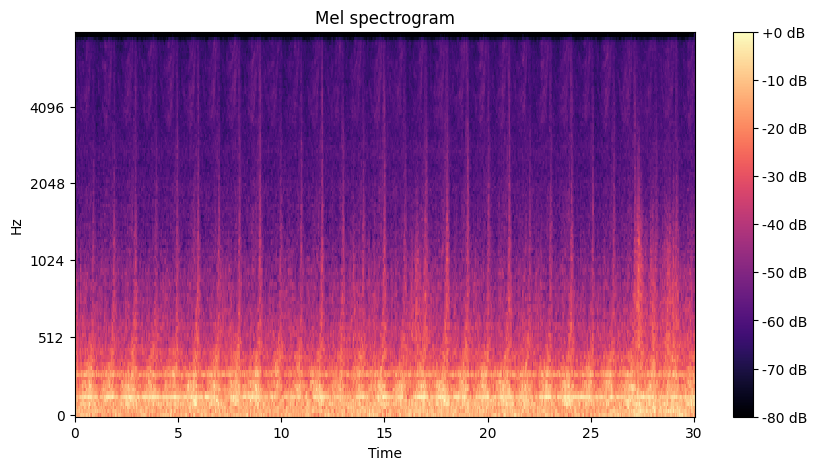

In [23]:
# 繪製頻譜圖    
plot_mel_spectrogram(mel_spectrograms[0], hop_length, target_sample_rate)

Number of peaks: 23


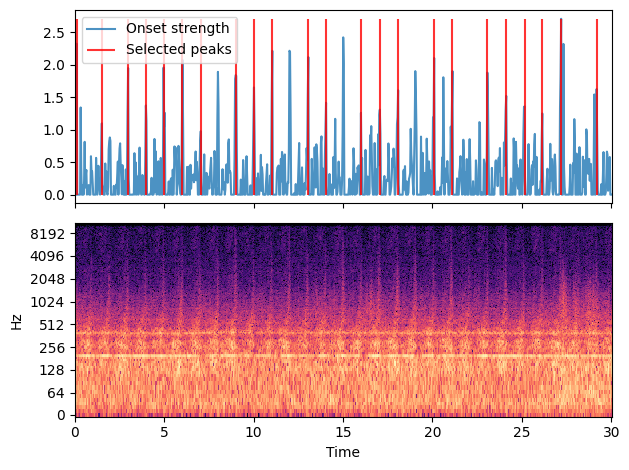

In [170]:
import matplotlib.pyplot as plt

def plot_onset_detection(wav, hop_length=512, target_sample_rate=16000):
    
    y, sr = wav
    if sr != target_sample_rate:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sample_rate)
        sr = target_sample_rate

    onset_env = librosa.onset.onset_strength(y=y, sr=sr,
                                             hop_length=hop_length,
                                             aggregate=np.median)

    peaks = librosa.util.peak_pick(onset_env, pre_max=20, post_max=20, pre_avg=50, post_avg=50, delta=0.5, wait=30)
    print(f'Number of peaks: {len(peaks)}')
    times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)

    fig, ax = plt.subplots(nrows=2, sharex=True)
    D = np.abs(librosa.stft(y))
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                             y_axis='log', x_axis='time', ax=ax[1], x_coords=times)  # 添加 x_coords 參數
    ax[0].plot(times, onset_env, alpha=0.8, label='Onset strength')
    ax[0].vlines(times[peaks], 0,
                 onset_env.max(), color='r', alpha=0.8,
                 label='Selected peaks')
    ax[0].legend(frameon=True, framealpha=0.8)
    ax[0].label_outer()

    plt.tight_layout()
    # save the plot
    plt.savefig('onset_detection.png')
    plt.show()

# 載入音訊數據
y, sr = loaded_files[0]

# 呼叫函式並傳遞參數
plot_onset_detection(loaded_files[0])

In [191]:
import numpy as np
import librosa

def segment_audio(wav, target_sr=16000, padding=1):
    """
    Segment audio into clips based on onset detection.

    :param wav: Tuple containing the audio time series data and sample rate (y, sr)
    :param target_sr: The target sample rate for resampling the audio (default: 16000)
    :return: A tuple containing a list of audio segments and the sample rate (segments, sr)
    """
    # 載入音訊數據
    y, sr = wav

    # 如果原始採樣率與目標採樣率不同,對音訊進行重採樣
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
        
    # 計算 onset envelope
    onset_env = librosa.onset.onset_strength(y=y, sr=sr,
                                         hop_length=512,
                                         aggregate= np.median)
    
    # 找出 onset 的峰值位置
    peaks = librosa.util.peak_pick(onset_env, pre_max=20, post_max=20, pre_avg=50, post_avg=50, delta=0.5, wait=30)
    
    # 將峰值位置轉換為時間戳
    peak_times = librosa.frames_to_time(peaks, sr=sr, hop_length=512)
    
    # 切割音訊, 允許重複擷取
    segments = []
    for peak_time in peak_times:
        # 根據 peak_time 計算起始和結束時間
        start_time = max(0, peak_time - padding)
        end_time = min(peak_time + padding, len(y) / sr)
        
        start_sample = int(start_time * sr)
        end_sample = int(end_time * sr)
        segment = y[start_sample:end_sample]
        segments.append(segment)
    
    return segments, sr

In [185]:
# Use Case
segments, sample_rate = segment_audio(loaded_files[0], target_sr=target_sample_rate, padding=1)
print(f'Number of segments: {len(segments)}')


Number of peaks: 23
Number of segments: 23


In [186]:
seg_idx = 8
display.Audio(segments[seg_idx], rate=sample_rate)

# 在同一張圖上繪製所有片段的頻譜圖

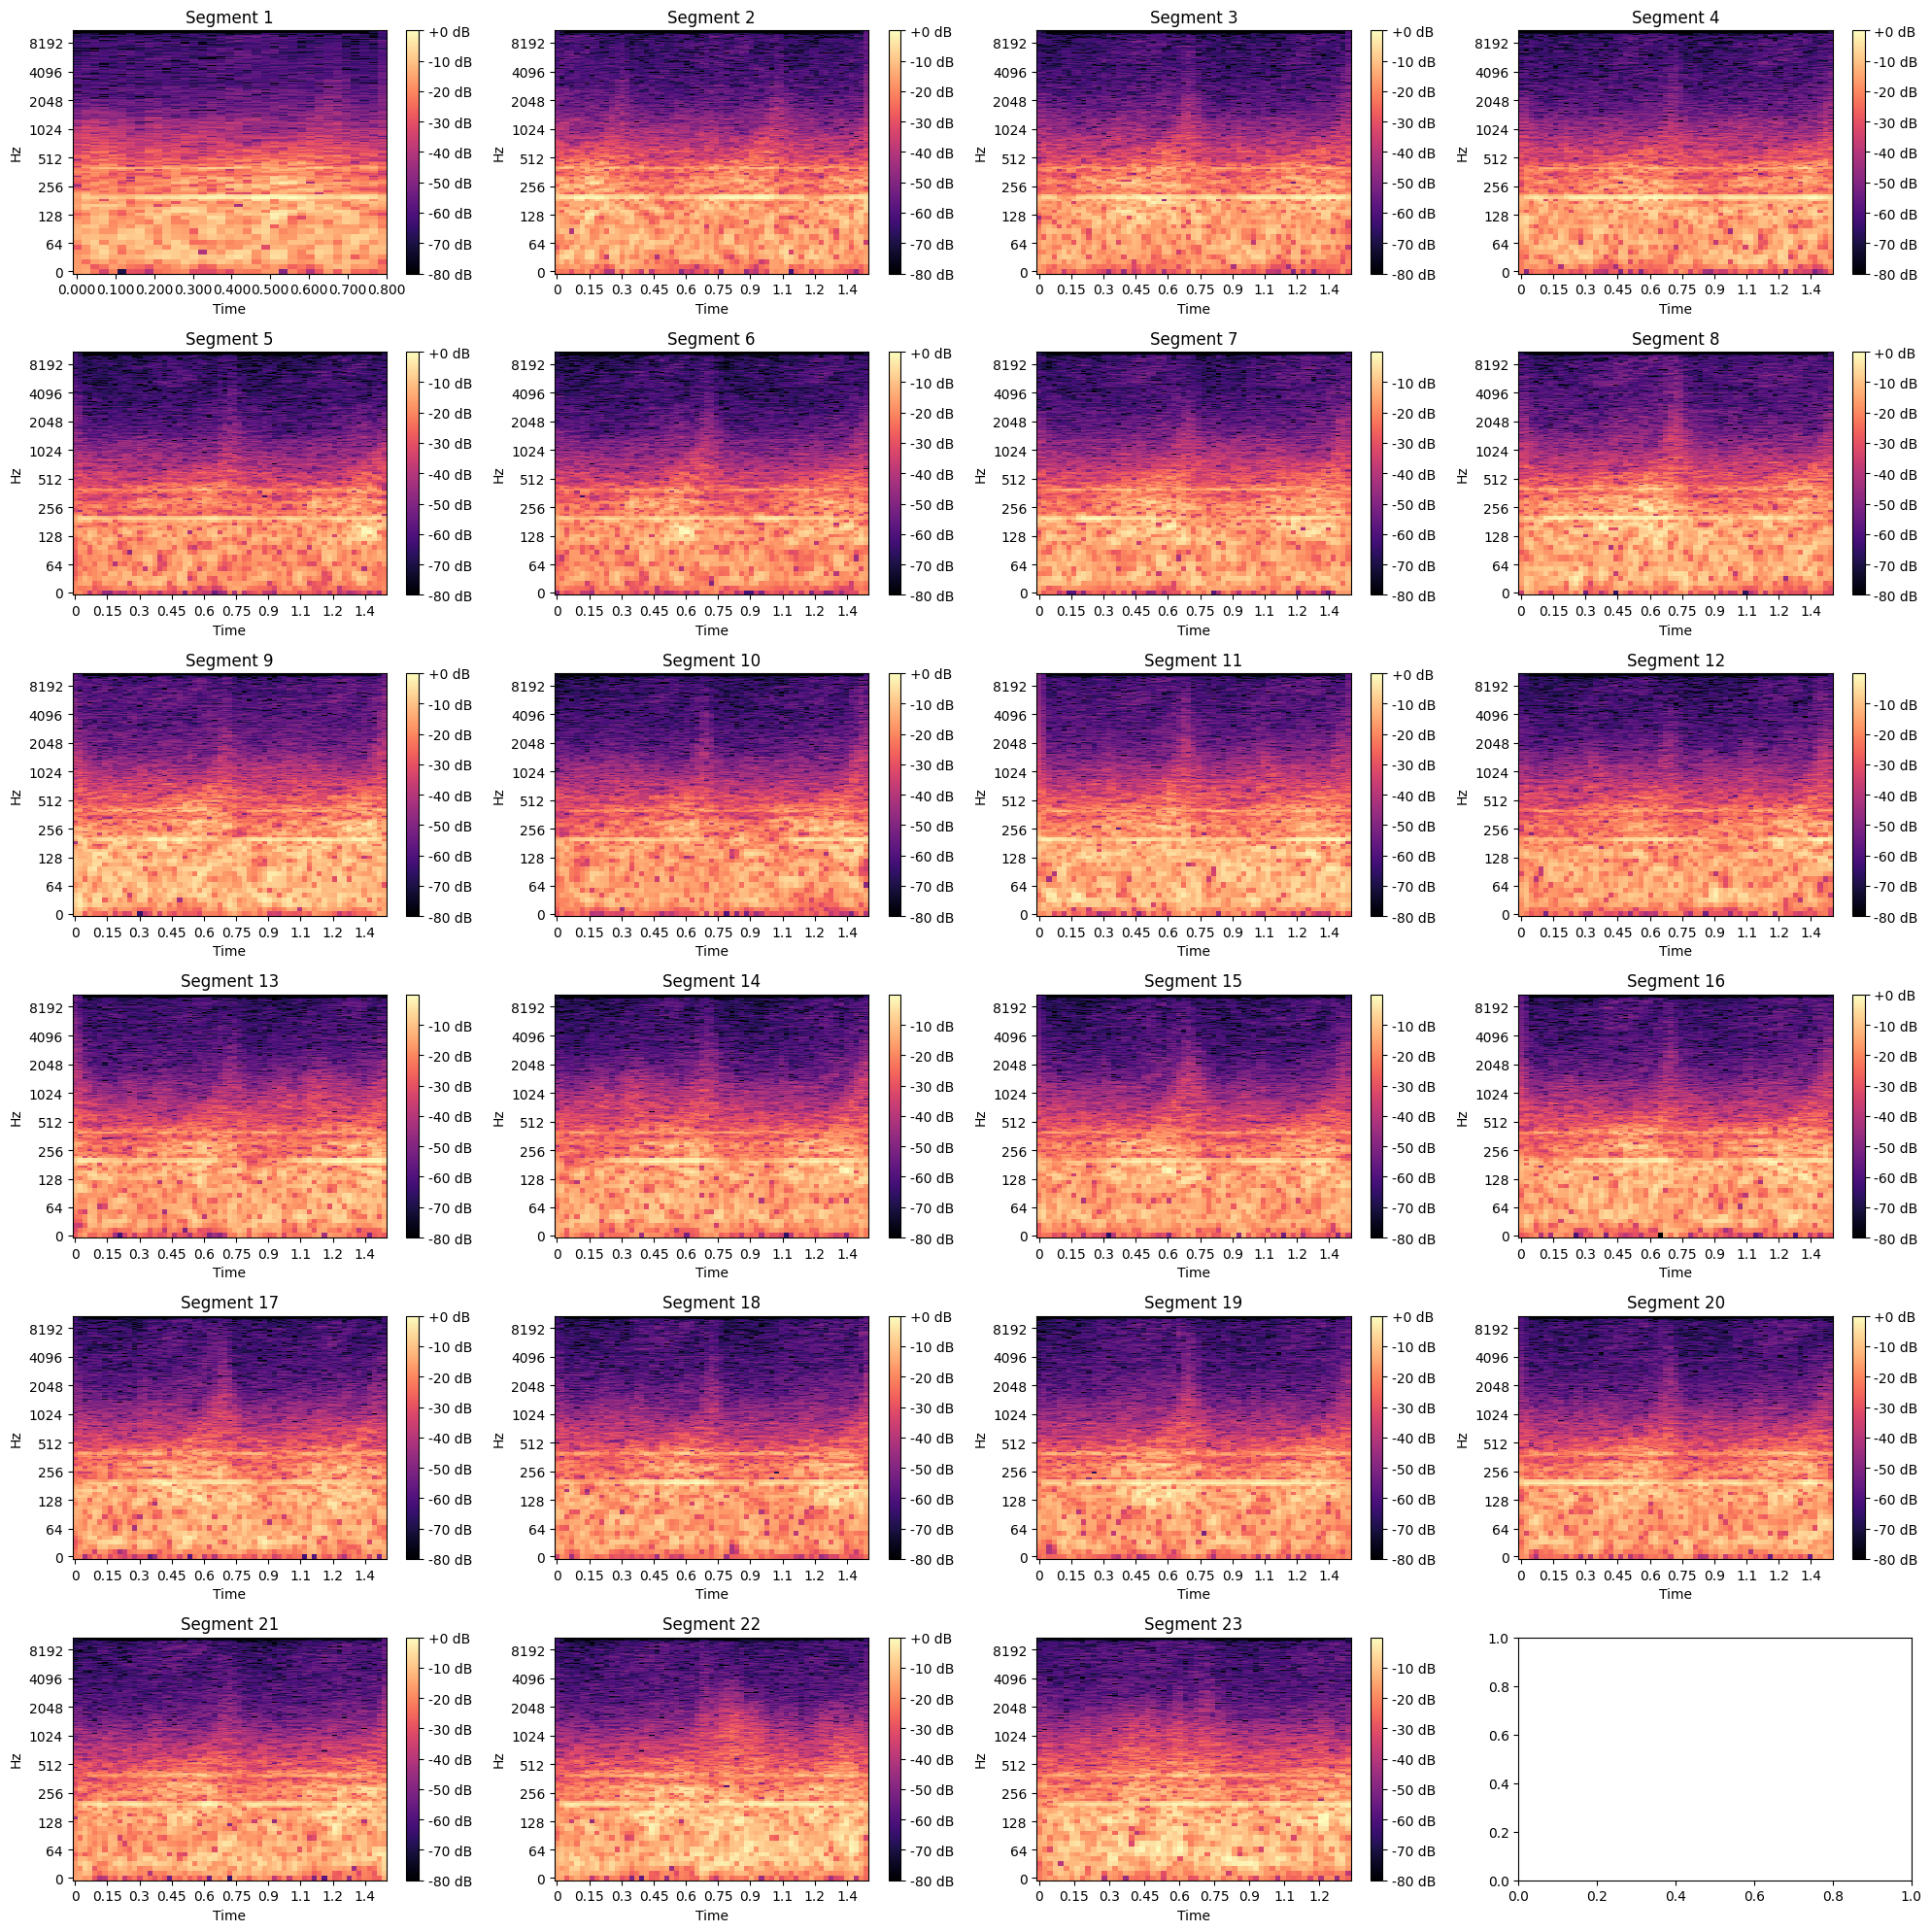

In [187]:
num_segments = len(segments)
num_cols = 4
num_rows = int(np.ceil(num_segments / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
fig.subplots_adjust(hspace=0.8) # 設置子圖之間的垂直間距
for seg_idx in range(num_segments):
    plt.subplot(num_rows, num_cols, seg_idx + 1)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(segments[seg_idx])), ref=np.max), y_axis='log', x_axis='time')
    plt.title(f'Segment {seg_idx + 1}')
    plt.colorbar(format='%+2.0f dB')
    
plt.savefig('segmented_spectrograms.png')
plt.tight_layout()
plt.show()

In [ ]:
import os
import soundfile as sf
from tqdm import tqdm

output_dir = "segmented_audio"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

total_files = len(loaded_files)
with tqdm(total=total_files, desc='Processing files', unit='file') as pbar:
    for i, wav in enumerate(loaded_files):
        segments, sample_rate = segment_audio(wav, target_sr=target_sample_rate, padding=1)
        pbar.set_postfix(file=f'{i + 1}/{total_files}', segments=len(segments))
        for j, segment in enumerate(segments):
            sf.write(f'{output_dir}/segment_{i}_{j}.wav', segment, sample_rate)
        pbar.update(1)

Processing files:   5%|▌         | 68/1243 [00:41<11:31,  1.70file/s, file=68/1243, segments=18]